In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
# tf.__version__

In [ ]:
import zipfile,os
 
base_dir = '/content/drive/MyDrive'
train_dir = os.path.join(base_dir, 'Kulit')

In [ ]:
os.listdir('/content/drive/MyDrive/Kulit')

['Panu', 'Kudis', 'Bisul', 'Biduran', 'Kurap']

In [ ]:
# Class Names
root_path = '/content/drive/MyDrive/Kulit/'
class_names = sorted(os.listdir(root_path))
n_classes = len(class_names)

# Class Distribution
class_dis = [len(os.listdir(root_path + name)) for name in class_names]

# Show
print(f"Total Number of Classes : {n_classes} \nClass Names : {class_names}")

Total Number of Classes : 5 
Class Names : ['Biduran', 'Bisul', 'Kudis', 'Kurap', 'Panu']


In [ ]:
print(len(os.listdir('/content/drive/MyDrive/Kulit/Panu')))
print(len(os.listdir('/content/drive/MyDrive/Kulit/Kurap')))
print(len(os.listdir('/content/drive/MyDrive/Kulit/Kudis')))
print(len(os.listdir('/content/drive/MyDrive/Kulit/Biduran')))
print(len(os.listdir('/content/drive/MyDrive/Kulit/Bisul')))

232
120
150
106
51


# Preprocessing

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
image_datagen = ImageDataGenerator(
                    # rescale=1./255,
                    rotation_range=90,
                    vertical_flip = True,
                    horizontal_flip=True,
                    shear_range = 0.1,
                    fill_mode = 'nearest',
                    validation_split = 0.2,
                    width_shift_range=0.2,
                    height_shift_range=0.2,)

# Rescale kalo resolusi gambar seragam
# Ga perlu rescale kalo resolusi beda-beda

train_generator = image_datagen.flow_from_directory(
        train_dir,
        subset='training',
        target_size=(300, 300),
        batch_size=32,
        class_mode='categorical'
        )

validation_generator = image_datagen.flow_from_directory(
        train_dir,
        subset='validation',
        target_size=(300, 300),
        batch_size=32,
        class_mode='categorical'
        )

Found 528 images belonging to 5 classes.
Found 131 images belonging to 5 classes.


# Transfer Learning

In [3]:
from tensorflow.keras.layers import Input , Dense , Flatten , GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential

transfer = tf.keras.applications.EfficientNetB4(
              input_shape=(300, 300, 3),
              include_top=False,
              weights='imagenet',
)
transfer.trainable = False
transfer.summary()

71686520/71686520 [==============================] - 4s 0us/step
Model: "efficientnetb4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 300, 300, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 300, 300, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TF

In [4]:
from tensorflow.keras.utils import plot_model

model = tf.keras.models.Sequential([
    transfer,
    tf.keras.layers.GlobalAveragePooling2D(),
    #Flatten
    tf.keras.layers.Flatten(),
    
    # Fully
    tf.keras.layers.Dense(1280, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='softmax')
])
# model.add(transfer)
# model.add(GlobalAveragePooling2D())
# model.add(Dropout(0.2))
# model.add(Dense(4,activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 10, 10, 1792)     17673823  
                                                                 
 global_average_pooling2d (G  (None, 1792)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1792)              0         
                                                                 
 dense (Dense)               (None, 1280)              2295040   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               163968    
                                                        

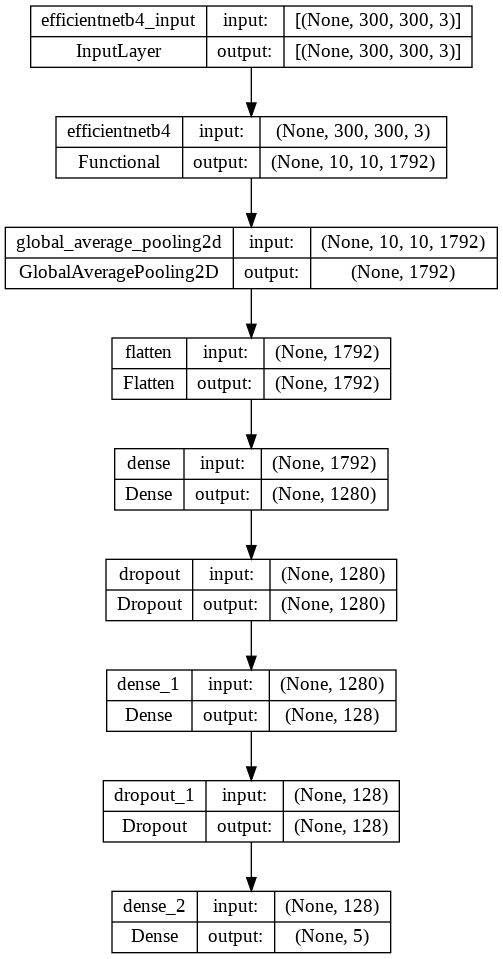

In [5]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=2e-3, momentum=0.9),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

reduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=10,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)

class stopTraining(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy') > 0.997 and logs.get('val_accuracy') < 100):
      print('Val Akurasi telah melebihi 99%')
      self.model.stop_training = True

early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
checkpoint = ModelCheckpoint("/content/drive/MyDrive/HasilTrain/kulit-B4.h5", monitor='val_accuracy', verbose=1, save_best_only=True)
callBack = stopTraining()

In [ ]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [ ]:
# latih model dengan model.fit 
history = model.fit(
      train_generator,                    
      epochs=1000,
      validation_data=validation_generator, 
      callbacks = [checkpoint, early, callBack],
      verbose=2
)

Epoch 1/1000

Epoch 1: val_accuracy improved from -inf to 0.38168, saving model to /content/drive/MyDrive/HasilTrain/kulit-B4.h5
17/17 - 368s - loss: 1.5332 - accuracy: 0.3106 - val_loss: 1.4458 - val_accuracy: 0.3817 - 368s/epoch - 22s/step
Epoch 2/1000

Epoch 2: val_accuracy improved from 0.38168 to 0.45802, saving model to /content/drive/MyDrive/HasilTrain/kulit-B4.h5
17/17 - 18s - loss: 1.4049 - accuracy: 0.4299 - val_loss: 1.2843 - val_accuracy: 0.4580 - 18s/epoch - 1s/step
Epoch 3/1000

Epoch 3: val_accuracy improved from 0.45802 to 0.61069, saving model to /content/drive/MyDrive/HasilTrain/kulit-B4.h5
17/17 - 18s - loss: 1.2497 - accuracy: 0.5189 - val_loss: 1.1411 - val_accuracy: 0.6107 - 18s/epoch - 1s/step
Epoch 4/1000

Epoch 4: val_accuracy improved from 0.61069 to 0.64122, saving model to /content/drive/MyDrive/HasilTrain/kulit-B4.h5
17/17 - 18s - loss: 1.1590 - accuracy: 0.5568 - val_loss: 1.0526 - val_accuracy: 0.6412 - 18s/epoch - 1s/step
Epoch 5/1000

Epoch 5: val_accur

# Visualization

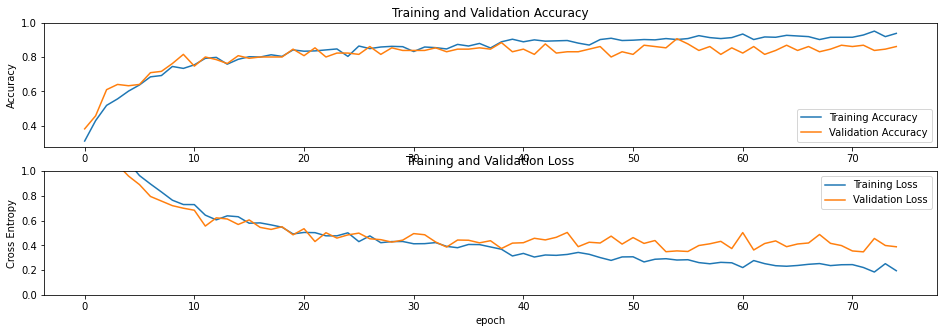

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 5))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Unfreezing
transfer.trainable = True

for layer in transfer.layers[:-10]:
    layer.trainable = False
        
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 10, 10, 1792)     17673823  
                                                                 
 global_average_pooling2d (G  (None, 1792)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1792)              0         
                                                                 
 dense (Dense)               (None, 1280)              2295040   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               163968    
                                                        

In [ ]:
# Fine Tuning
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

history = model.fit(
      train_generator,                    
      epochs=1000,                              # tambahkan epochs jika akurasi model belum optimal
      validation_data=validation_generator,   # menampilkan akurasi pengujian data validasi
      callbacks = [checkpoint, early, callBack],
      verbose=2
)

Epoch 1/1000

Epoch 1: val_accuracy did not improve from 0.90840
17/17 - 31s - loss: 0.3643 - accuracy: 0.9072 - val_loss: 0.4678 - val_accuracy: 0.7939 - 31s/epoch - 2s/step
Epoch 2/1000

Epoch 2: val_accuracy did not improve from 0.90840
17/17 - 16s - loss: 0.4043 - accuracy: 0.8807 - val_loss: 0.3358 - val_accuracy: 0.9084 - 16s/epoch - 914ms/step
Epoch 3/1000

Epoch 3: val_accuracy did not improve from 0.90840
17/17 - 16s - loss: 0.3716 - accuracy: 0.9015 - val_loss: 0.3055 - val_accuracy: 0.9008 - 16s/epoch - 919ms/step
Epoch 4/1000

Epoch 4: val_accuracy did not improve from 0.90840
17/17 - 15s - loss: 0.3817 - accuracy: 0.9091 - val_loss: 0.4007 - val_accuracy: 0.8626 - 15s/epoch - 909ms/step
Epoch 5/1000

Epoch 5: val_accuracy did not improve from 0.90840
17/17 - 15s - loss: 0.4097 - accuracy: 0.8883 - val_loss: 0.4173 - val_accuracy: 0.8550 - 15s/epoch - 912ms/step
Epoch 6/1000

Epoch 6: val_accuracy did not improve from 0.90840
17/17 - 18s - loss: 0.3753 - accuracy: 0.9072 - 

# Test

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/HasilTrain/kulit-B4.h5')

In [ ]:
import tensorflow as tf
from keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing import image
import numpy as np
import os
import matplotlib.pyplot as plt

In [ ]:
classes=['Biduran', 'Bisul', 'Kudis', 'Kurap', 'Panu']

In [ ]:
test_path = '/content/drive/MyDrive/HasilTrain/test/'

test_gen = ImageDataGenerator(
    # rescale=1/255.,
    rotation_range=90,
    vertical_flip=True,
    horizontal_flip=True,
    shear_range = 0.1,
    )

test_ds = test_gen.flow_from_directory(
    test_path, 
    target_size=(300, 300),
    batch_size=32,
    class_mode='categorical',
    shuffle=True, 
    )

Found 69 images belonging to 5 classes.


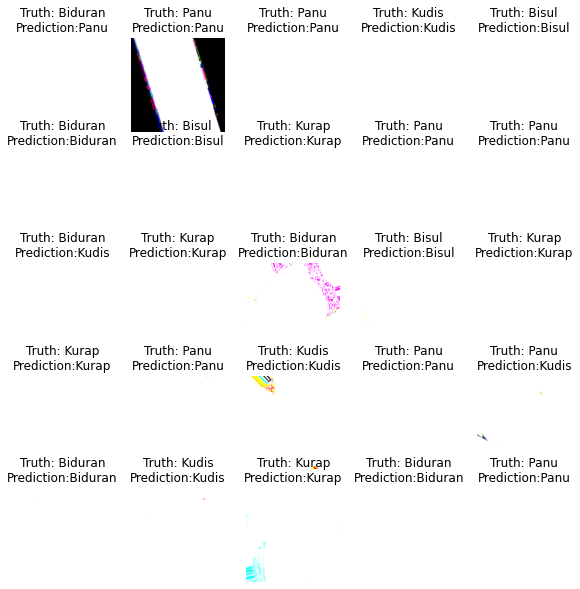

In [ ]:
plt.figure(figsize=(10, 10))
x, label= test_ds.next()
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(x[i])
    result = np.where(label[i]==1)
    predict = model(tf.expand_dims(x[i], 0))
    score = tf.nn.softmax(predict[0])
    score_label = classes[np.argmax(score)]
    plt.title(f'Truth: {classes[result[0][0]]}\nPrediction:{score_label}')
    plt.axis(False)

In [ ]:
results = model.evaluate(test_ds)
print(f"test loss {results[0]}, test accuracy {results[1]}")

3/3 [==============================] - 2s 374ms/step - loss: 0.3204 - accuracy: 0.9275
test loss 0.3203752040863037, test accuracy 0.9275362491607666


#========================================================

In [ ]:
test_path = '../input/4-animal-classification/test/test'
test_gen = image_datagen.flow_from_directory(    
    directory=test_path,
    target_size=(300, 300),
    batch_size=32,
    classes=['.'],
    shuffle=False,
)

Found 729 images belonging to 1 classes.


In [ ]:
from PIL import Image
predict = []

In [ ]:
import numpy as np
for i in range(1,730):
    img = Image.open('../input/4-animal-classification/test/test/'+str(i)+'.jpg')
    img = img.resize((300,300))
    c_predict = hypermodel.predict(np.asarray(img).reshape(-1,300,300,3))
    predict.append(c_predict)
    if(i % 100 == 0):
        print(i, "Predicted")

100 Predicted
200 Predicted
300 Predicted
400 Predicted
500 Predicted
600 Predicted
700 Predicted


In [ ]:
import pandas as pd
predictions = np.argmax(predict,axis=2)
submission_file = pd.read_csv("../input/4-animal-classification/Sample_submission.csv")
submission_file['Label'] = predictions
submission_file.to_csv('submission7.csv', index=False)
submission_file['Label'].value_counts()

2    231
0    198
3    165
1    135
Name: Label, dtype: int64

In [ ]:
submission_file

,ID,Label
0,1,1
1,2,0
2,3,2
3,4,3
4,5,2
...,...,...
724,725,1
725,726,2
726,727,2
727,728,2


In [ ]:
from keras.models import load_model

model.save('latest_my_model.h5')  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
# model = load_model('my_model.h5')

In [ ]:
import matplotlib.pyplot as plt

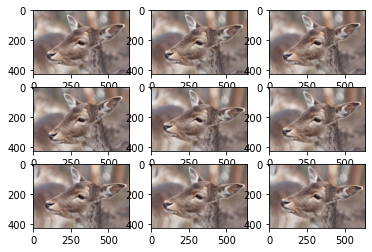

In [ ]:
# https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
# example of random rotation image augmentation
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# load the image
img = load_img('../input/4-animal-classification/test/test/1.jpg')
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(rotation_range=20)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

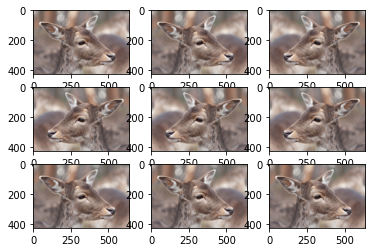

In [ ]:
# https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
# example of random rotation image augmentation
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# load the image
img = load_img('../input/4-animal-classification/test/test/1.jpg')
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(horizontal_flip='True')
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

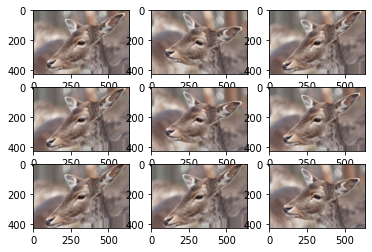

In [ ]:
# https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
# example of random rotation image augmentation
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# load the image
img = load_img('../input/4-animal-classification/test/test/1.jpg')
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(shear_range=20)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

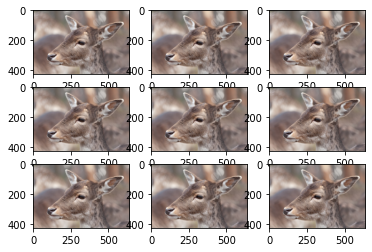

In [ ]:
# https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
# example of random rotation image augmentation
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# load the image
img = load_img('../input/4-animal-classification/test/test/1.jpg')
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(fill_mode='nearest')
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

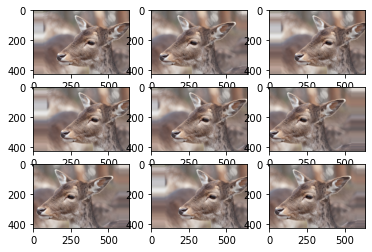

In [ ]:
# https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
# example of random rotation image augmentation
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# load the image
img = load_img('../input/4-animal-classification/test/test/1.jpg')
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(width_shift_range=0.2)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

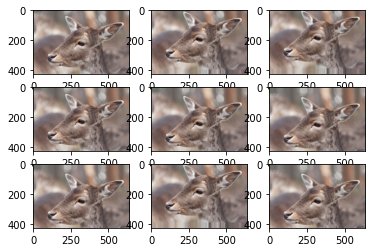

In [ ]:
# https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
# example of random rotation image augmentation
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# load the image
img = load_img('../input/4-animal-classification/test/test/1.jpg')
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(height_shift_range=0.1)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()